In [480]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import warnings
import sys
sys.path.insert(0,'../')
from example.fit_with_GIdisk.find_center import find_center
from astropy.modeling.models import Gaussian2D
from astropy.modeling.fitting import LevMarLSQFitter

In [481]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord
import astropy.constants as const
au = const.au.cgs.value
pc = const.pc.cgs.value

distance_pc = 140

cmap = 'viridis'

In [482]:
def get_info(fname):
    with fits.open(fname) as hdul:
        data = hdul[0].data
        header = hdul[0].header
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            wcs = WCS(header=header)
        # Loop through all HDUs and print headers
        for i, hdu in enumerate(hdul):
            print(f"HDU {i}:")
            print(repr(hdu.header))
            if repr(hdu.header).startswith('HISTORY'):
                break
    return data, header, wcs

def get_beam_axis(header, distance_pc):
    au_per_pix = abs(header['CDELT1'])/180*np.pi*distance_pc*pc/au
    if 'BMAJ' in header and 'BMIN' in header and 'BPA' in header:
        beam_major_arcsec = header['BMAJ'] * 3600  # Major axis in arcseconds
        beam_minor_arcsec = header['BMIN'] * 3600  # Minor axis in arcseconds
        beam_major_pixels = (header['BMAJ']/180*np.pi)*distance_pc*pc/au / au_per_pix
        beam_minor_pixels = (header['BMIN']/180*np.pi)*distance_pc*pc/au / au_per_pix
        beam_pa = header['BPA']  # Position angle in degrees
    else:
        raise ValueError("Beam size (BMAJ and BMIN) not found in FITS header.")
    return (beam_major_arcsec, beam_minor_arcsec), (beam_major_pixels, beam_minor_pixels), beam_pa, au_per_pix

def get_peak(data):
    # Mask NaN values and replace them with 0
    if np.isnan(data).any():
        data = np.where(np.isnan(data), 0, data)
    
    # Find the maximum value in the cleaned data
    peak = np.max(data)
    
    return peak * 1e3  # Convert to mJy/beam

def get_flux(header, data, x_lim=None, y_lim=None):

    # Pixel scale in degrees (CDELT1 or CD1_1)
    pixel_scale_deg = abs(header.get('CDELT1', 1))  # Fallback to 1 degree if not present
    pixel_scale_arcsec = pixel_scale_deg * 3600  # Convert to arcseconds

    # Extract beam size from FITS header
    if 'BMAJ' in header and 'BMIN' in header:
        beam_major_arcsec = header['BMAJ'] * 3600  # Major axis in arcseconds
        beam_minor_arcsec = header['BMIN'] * 3600  # Minor axis in arcseconds
        beam_area_arcsec2 = (np.pi * beam_major_arcsec * beam_minor_arcsec) / (4 * np.log(2))
    else:
        raise ValueError("Beam size (BMAJ and BMIN) not found in FITS header.")

    # Estimate the source location (rough cropping for fitting)
    if x_lim is None:
        x_lim = [data.shape[1]//2-data.shape[1]//20, data.shape[1]//2+data.shape[1]//20]
    if y_lim is None:
        y_lim = [data.shape[0]//2-data.shape[0]//20, data.shape[0]//2+data.shape[0]//20]

    x_min, x_max = x_lim[0], x_lim[1]
    y_min, y_max = y_lim[0], y_lim[1]
    cropped_data = data[y_min:y_max, x_min:x_max]

    # Create grid for fitting
    y, x = np.mgrid[:cropped_data.shape[0], :cropped_data.shape[1]]

    # Initialize a 2D Gaussian model with an initial guess
    gaussian_init = Gaussian2D(amplitude=np.max(cropped_data),
                               x_mean=(x_max - x_min) // 2,
                               y_mean=(y_max - y_min) // 2,
                               x_stddev=5, y_stddev=5)

    # Fit the Gaussian model
    fitter = LevMarLSQFitter()
    fitted_gaussian = fitter(gaussian_init, x, y, cropped_data)

    # Extract fitted parameters
    x_stddev = fitted_gaussian.x_stddev.value  # In pixels
    y_stddev = fitted_gaussian.y_stddev.value  # In pixels

    # Convert beam FWHM to standard deviation in pixels
    beam_stddev = np.sqrt(beam_area_arcsec2 / (pixel_scale_arcsec**2 * np.pi))

    # Deconvolved sizes
    deconvolved_x_stddev = np.sqrt(max(0, x_stddev**2))
    deconvolved_y_stddev = np.sqrt(max(0, y_stddev**2))

    # FWHM in arcseconds
    deconvolved_x_fwhm = 2.35482 * deconvolved_x_stddev * pixel_scale_arcsec
    deconvolved_y_fwhm = 2.35482 * deconvolved_y_stddev * pixel_scale_arcsec

    theta = fitted_gaussian.theta.value

    # Calculate residual image
    model_image = fitted_gaussian(x, y)
    residual = cropped_data - model_image

    # Calculate RMS noise from residual
    rms_noise = np.std(residual)

    # Calculate flux density within 3 sigma region
    threshold = 3 * rms_noise
    mask = cropped_data > threshold  # Mask for 3-sigma region
    num_pixels = np.sum(mask)
    total_flux_jy_beam = np.sum(cropped_data[mask])  # Total flux in Jy/beam
    num_beams = (num_pixels * pixel_scale_arcsec**2) / beam_area_arcsec2
    flux_density_3sigma = total_flux_jy_beam / num_beams  # Convert to Jy

    return flux_density_3sigma, deconvolved_x_fwhm, deconvolved_y_fwhm, theta, rms_noise

def crop_image(data, header, x_lim=None, y_lim=None, size_au=None, size_arcsec=None):
    # Estimate the source location (rough cropping for fitting)
    if x_lim is None:
        x_lim = [data.shape[1]//2-data.shape[1]//20, data.shape[1]//2+data.shape[1]//20]
    if y_lim is None:
        y_lim = [data.shape[0]//2-data.shape[0]//20, data.shape[0]//2+data.shape[0]//20]

    x_min, x_max = x_lim[0], x_lim[1]
    y_min, y_max = y_lim[0], y_lim[1]
    cropped_data = data[y_min:y_max, x_min:x_max]

    return cropped_data


In [483]:
cb68_eDisk = "~/project_data/cb68_edisk/CB68_SBLB_continuum_robust_0.0.image.tt0.fits"
cb68_faust_setup1 = "~/project_data/cb68_faust/cb68_setup1_all.rob2.I.image.tt0.pbcor.smooth.dropdeg.fits"
cb68_faust_setup2 = "~/project_data/cb68_faust/cb68_setup2_all.rob2.I.image.tt0.pbcor.smooth.dropdeg.fits"
cb68_faust_setup3 = "~/project_data/cb68_faust/cb68_setup3_all.rob2.I.image.tt0.pbcor.smooth.dropdeg.fits"

## eDisk (233.8 GHz/1.3mm)

In [484]:
data, header, wcs = get_info(cb68_eDisk)

HDU 0:
SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    2                                                  
NAXIS1  =                 6000                                                  
NAXIS2  =                 6000                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   1.009759182731E-05                                                  
BMIN    =   7.617855961952E-06                                                  
BPA     =   6.939870452881E+01                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = 'CB68    ' 

In [485]:
beam_arcsec, beam_pixel, beam_pa, au_per_pix = get_beam_axis(header=header, distance_pc=distance_pc)
beam_major_arcsec, beam_minor_arcsec = beam_arcsec
beam_major_pixels, beam_minor_pixels = beam_pixel

print(f"Beam major axis: {beam_major_arcsec:.4f} arcsec")
print(f"Beam minor axis: {beam_minor_arcsec:.4f} arcsec")
print(f"Beam major axis: {beam_major_pixels:.4f} pixels")
print(f"Beam minor axis: {beam_minor_pixels:.4f} pixels")
print(f"Beam position angle: {beam_pa:.2f} degrees")


Beam major axis: 0.0364 arcsec
Beam minor axis: 0.0274 arcsec
Beam major axis: 12.1171 pixels
Beam minor axis: 9.1414 pixels
Beam position angle: 69.40 degrees


In [ ]:
peak = get_peak(data=data)
print(f"Peak intensity: {peak:.2f} mJy/beam")

Peak intensity: 4.04 mJy/beam


In [509]:
ra_center, dec_center, _ = find_center(cb68_eDisk, x_lim=[5000, 7000], y_lim=[5000, 7000])

# Crop region
ra_min  = '16:57:19.656'
ra_max  = '16:57:19.63'
dec_min = '-16:09:24.2'
dec_max = '-16:09:23.8'
# Convert WCS to pixel coordinates
coord_min = SkyCoord(ra=ra_min, dec=dec_min, unit=('hourangle', 'deg'))
coord_max = SkyCoord(ra=ra_max, dec=dec_max, unit=('hourangle', 'deg'))
x_min, y_min = skycoord_to_pixel(coord_min, wcs)
x_max, y_max = skycoord_to_pixel(coord_max, wcs)
x_min, x_max = int(x_min), int(x_max)
y_min, y_max = int(y_min), int(y_max)

cropped_data = data[y_min:y_max, x_min:x_max]
cropped_wcs = wcs.slice((slice(y_min, y_max), slice(x_min, x_max)))

## FAUST 1.3mm (Setup 1: 233.8 GHz)

In [487]:
data, header, wcs = get_info(cb68_faust_setup1)

HDU 0:
SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    2                                                  
NAXIS1  =                 2560                                                  
NAXIS2  =                 2560                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   1.888888870472E-04                                                  
BMIN    =   1.611111111088E-04                                                  
BPA     =  -8.999999952148E+01                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = '        ' 

In [488]:
beam_arcsec, beam_pixel, beam_pa, au_per_pix = get_beam_axis(header=header, distance_pc=distance_pc)
beam_major_arcsec, beam_minor_arcsec = beam_arcsec
beam_major_pixels, beam_minor_pixels = beam_pixel

print(f"Beam major axis: {beam_major_arcsec:.4f} arcsec")
print(f"Beam minor axis: {beam_minor_arcsec:.4f} arcsec")
print(f"Beam major axis: {beam_major_pixels:.4f} pixels")
print(f"Beam minor axis: {beam_minor_pixels:.4f} pixels")
print(f"Beam position angle: {beam_pa:.2f} degrees")

Beam major axis: 0.6800 arcsec
Beam minor axis: 0.5800 arcsec
Beam major axis: 22.6667 pixels
Beam minor axis: 19.3333 pixels
Beam position angle: -90.00 degrees


In [489]:
peak = get_peak(data=data)
print(f"Peak intensity: {peak:.2f} mJy/beam")

Peak intensity: 53.44 mJy/beam


## FAUST 1.2mm (Setup 2: 246.7 GHz)

In [490]:
data, header, wcs = get_info(cb68_faust_setup2)

HDU 0:
SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    2                                                  
NAXIS1  =                 2560                                                  
NAXIS2  =                 2560                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   1.893309917715E-04                                                  
BMIN    =   1.608107818498E-04                                                  
BPA     =  -8.986162567139E+01                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = 'CB68    ' 

In [491]:
beam_arcsec, beam_pixel, beam_pa, au_per_pix = get_beam_axis(header=header, distance_pc=distance_pc)
beam_major_arcsec, beam_minor_arcsec = beam_arcsec
beam_major_pixels, beam_minor_pixels = beam_pixel

print(f"Beam major axis: {beam_major_arcsec:.4f} arcsec")
print(f"Beam minor axis: {beam_minor_arcsec:.4f} arcsec")
print(f"Beam major axis: {beam_major_pixels:.4f} pixels")
print(f"Beam minor axis: {beam_minor_pixels:.4f} pixels")
print(f"Beam position angle: {beam_pa:.2f} degrees")

Beam major axis: 0.6816 arcsec
Beam minor axis: 0.5789 arcsec
Beam major axis: 22.7197 pixels
Beam minor axis: 19.2973 pixels
Beam position angle: -89.86 degrees


In [492]:
peak = get_peak(data=data)
print(f"Peak intensity: {peak:.2f} mJy/beam")

Peak intensity: 58.55 mJy/beam


## FAUST 3.2mm (Setup 3: 95.0 GHz)

In [493]:
data, header, wcs = get_info(cb68_faust_setup3)

HDU 0:
SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    2                                                  
NAXIS1  =                 2560                                                  
NAXIS2  =                 2560                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   1.888888889074E-04                                                  
BMIN    =   1.611111110341E-04                                                  
BPA     =  -8.999999992089E+01                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = '        ' 

In [494]:
beam_arcsec, beam_pixel, beam_pa, au_per_pix = get_beam_axis(header=header, distance_pc=distance_pc)
beam_major_arcsec, beam_minor_arcsec = beam_arcsec
beam_major_pixels, beam_minor_pixels = beam_pixel

print(f"Beam major axis: {beam_major_arcsec:.4f} arcsec")
print(f"Beam minor axis: {beam_minor_arcsec:.4f} arcsec")
print(f"Beam major axis: {beam_major_pixels:.4f} pixels")
print(f"Beam minor axis: {beam_minor_pixels:.4f} pixels")
print(f"Beam position angle: {beam_pa:.2f} degrees")


Beam major axis: 0.6800 arcsec
Beam minor axis: 0.5800 arcsec
Beam major axis: 22.6667 pixels
Beam minor axis: 19.3333 pixels
Beam position angle: -90.00 degrees


In [495]:
peak = get_peak(data=data)
print(f"Peak intensity: {peak:.2f} mJy/beam")

Peak intensity: 7.08 mJy/beam


In [496]:
ra_center, dec_center, _ = find_center(cb68_eDisk, x_lim=[5000, 7000], y_lim=[5000, 7000])

icx_float = (ra_center-header['CRVAL1'])/header['CDELT1']+header['CRPIX1']-1
icy_float = (dec_center-header['CRVAL2'])/header['CDELT2']+header['CRPIX2']-1
icx = int(icx_float)
icy = int(icy_float)

# Crop region
ra_min  = '16:57:19.656'
ra_max  = '16:57:19.63'
dec_min = '-16:09:24.2'
dec_max = '-16:09:23.8'
# Convert WCS to pixel coordinates
coord_min = SkyCoord(ra=ra_min, dec=dec_min, unit=('hourangle', 'deg'))
coord_max = SkyCoord(ra=ra_max, dec=dec_max, unit=('hourangle', 'deg'))
x_min, y_min = skycoord_to_pixel(coord_min, wcs)
x_max, y_max = skycoord_to_pixel(coord_max, wcs)
x_min, x_max = int(x_min), int(x_max)
y_min, y_max = int(y_min), int(y_max)

cropped_data = data[y_min:y_max, x_min:x_max]
cropped_wcs = wcs.slice((slice(y_min, y_max), slice(x_min, x_max)))

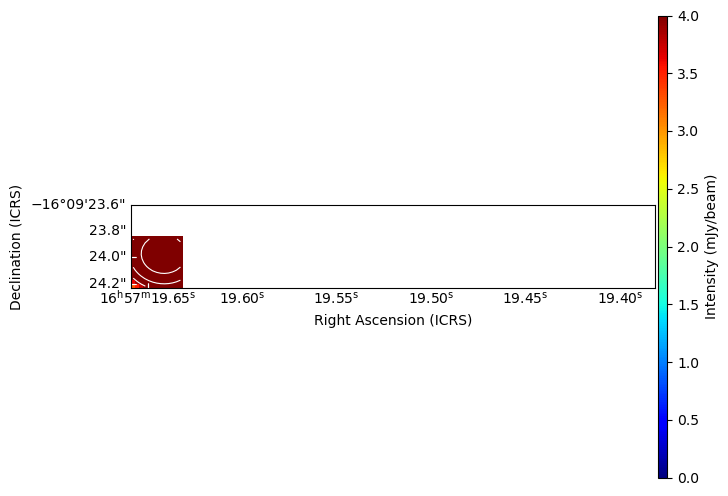

In [497]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(projection=cropped_wcs)

im = ax.imshow(cropped_data*1e3, cmap='jet', origin='lower', vmin=0.00, vmax=4)
colorbar = fig.colorbar(im, ax=ax, pad=0.005, aspect=50)
colorbar.set_label('Intensity (mJy/beam)')

sigma_levels = [5, 20, 40, 60, 80, 100, 120, 150]
contour_levels = [level * rms_noise for level in sigma_levels]
contours = ax.contour(cropped_data, levels=contour_levels, colors='w', linewidths=0.8)

beam = Ellipse((115, 10), width=beam_minor_pixels, height=beam_major_pixels,
               angle=beam_pa, edgecolor='w', facecolor='w', lw=1.5, fill=True)
ax.add_patch(beam)

plt.plot([30-10/au_per_pix, 30+10/au_per_pix],[10, 10], "w", lw=3)
plt.text(30, 15, '20 AU', color='w', ha='center', va='top')

ax.set_xlabel('Right Ascension (ICRS)')
ax.set_ylabel('Declination (ICRS)')
plt.tick_params(direction='in', color='w')
plt.savefig('CB68_conti_edisk.pdf', transparent=True)

In [498]:
plt.close('all')

In [499]:
cb68_faust = "/Users/hyp0515/project_data/cb68_faust/cb68_setup3_all.rob2.I.image.tt0.pbcor.smooth.dropdeg.fits"

In [500]:
flux, fwhm_x, fwhm_y, theta, rms = get_flux(cb68_faust)
print("Flux density: {:.4f} mJy".format(flux * 1e3))
print("FWHM in x: {:.4f} arcsec".format(fwhm_x))
print("FWHM in y: {:.4f} arcsec".format(fwhm_y))
print("Position angle: {:.4f} degrees".format(theta/np.pi*180))
print("RMS noise: {:.4f} mJy".format(rms * 1e3))

Flux density: 570.7438 mJy
FWHM in x: 0.7075 arcsec
FWHM in y: 0.6147 arcsec
Position angle: -3.3211 degrees
RMS noise: 0.0304 mJy


In [501]:
with fits.open(cb68_faust) as hdul:
    # Loop through all HDUs and print headers
    for i, hdu in enumerate(hdul):
        print(f"HDU {i}:")
        print(repr(hdu.header))

HDU 0:
SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    2                                                  
NAXIS1  =                 2560                                                  
NAXIS2  =                 2560                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   1.888888889074E-04                                                  
BMIN    =   1.611111110341E-04                                                  
BPA     =  -8.999999992089E+01                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = '        ' 

In [502]:
hdul = fits.open(cb68_faust)
data = hdul[0].data
header = hdul[0].header
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    wcs = WCS(header=header)
hdul.close()

In [503]:
rms_noise = 40e-6
distance_pc = 140  # Distance in parsecs

beam_major = header['BMAJ']
beam_minor = header['BMIN']
beam_pa = header['BPA']
signx = int(-np.sign(header['CDELT1'])) # x propto minus RA
signy = int(np.sign(header['CDELT2'])) 
au_per_pix = abs(header['CDELT1'])/180*np.pi*distance_pc*pc/au
beam_major_pixels = (header['BMAJ']/180*np.pi)*distance_pc*pc/au / au_per_pix
beam_minor_pixels = (header['BMIN']/180*np.pi)*distance_pc*pc/au / au_per_pix

In [504]:
ra_center, dec_center, _ = find_center(cb68_faust, x_lim=[1200, 1360], y_lim=[1200, 1360])

icx_float = (ra_center-header['CRVAL1'])/header['CDELT1']+header['CRPIX1']-1
icy_float = (dec_center-header['CRVAL2'])/header['CDELT2']+header['CRPIX2']-1
icx = int(icx_float)
icy = int(icy_float)

# Crop region
ra_min  = '16:57:19.75'
ra_max  = '16:57:19.55'
dec_min = '-16:09:26'
dec_max = '-16:09:22'
# Convert WCS to pixel coordinates
coord_min = SkyCoord(ra=ra_min, dec=dec_min, unit=('hourangle', 'deg'))
coord_max = SkyCoord(ra=ra_max, dec=dec_max, unit=('hourangle', 'deg'))
x_min, y_min = skycoord_to_pixel(coord_min, wcs)
x_max, y_max = skycoord_to_pixel(coord_max, wcs)
x_min, x_max = int(x_min), int(x_max)
y_min, y_max = int(y_min), int(y_max)

x_min, x_max = int(1230), int(1330)
y_min, y_max = int(1230), int(1330)


cropped_data = data[y_min:y_max, x_min:x_max]
cropped_wcs = wcs.slice((slice(y_min, y_max), slice(x_min, x_max)))

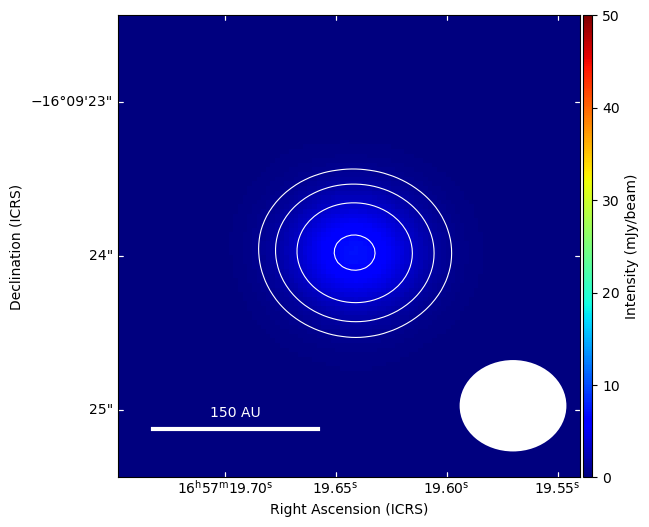

In [505]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(projection=cropped_wcs)

im = ax.imshow(cropped_data*1e3, cmap='jet', origin='lower', vmin=0.00, vmax=50)
colorbar = fig.colorbar(im, ax=ax, pad=0.005, aspect=50)
colorbar.set_label('Intensity (mJy/beam)')

sigma_levels = [20, 40, 80, 160, 320, 640]
contour_levels = [level * rms_noise for level in sigma_levels]
contours = ax.contour(cropped_data, levels=contour_levels, colors='w', linewidths=0.8)

beam = Ellipse((85, 15), width=beam_minor_pixels, height=beam_major_pixels,
               angle=beam_pa, edgecolor='w', facecolor='w', lw=1.5, fill=True)
ax.add_patch(beam)

plt.plot([25-75/au_per_pix, 25+75/au_per_pix],[10, 10], "w", lw=3)
plt.text(25, 15, '150 AU', color='w', ha='center', va='top')
ax.set_xlabel('Right Ascension (ICRS)')
ax.set_ylabel('Declination (ICRS)')
plt.tick_params(direction='in', color='w')
plt.savefig('CB68_conti_faust.pdf', transparent=True)

In [506]:
plt.close('all')

In [507]:
cb68_faust = "/Users/hyp0515/project_data/cb68_faust/cb68_setup2_all.rob2.I.image.tt0.pbcor.smooth.dropdeg.fits"

In [508]:
with fits.open(cb68_faust) as hdul:
    # Loop through all HDUs and print headers
    for i, hdu in enumerate(hdul):
        print(f"HDU {i}:")
        print(repr(hdu.header))

HDU 0:
SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    2                                                  
NAXIS1  =                 2560                                                  
NAXIS2  =                 2560                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   1.893309917715E-04                                                  
BMIN    =   1.608107818498E-04                                                  
BPA     =  -8.986162567139E+01                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = 'CB68    ' 